# AIM: develop the pretext task with EEGNet
Across subject pretext task

In [1]:
import numpy as np
import pandas as pd
import mne
import lightning.pytorch as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchmetrics import F1Score, Accuracy
import random
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
import itertools
from torch.utils.data import Dataset, DataLoader, Subset
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

## Pretext task

#### Functions & Classes

In [2]:
def get_participant_ids(eeg_dir, epoch_dir=False):
    """
    Function to get all participant ids from EEG data directory
    :param eeg_dir: directory where EEG data is stored
    :param epoch_dir: whether the data that we want to retrieve is from the epoch directory or from the raw EEG data directory
    :return: list of participant ids
    """
    participant_ids = []
    if epoch_dir == False:
        for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
            for file in files:
                if 'ses-1' in file and '.npy' in file and 'BAD' not in file: # filter first session, .npy files, and non-bad files
                    participant_id = file.split('_')[0] # extract participant id
                    if participant_id not in participant_ids:
                        participant_ids.append(participant_id)
    else:
        participant_ids = [file.split('.')[0] for file in os.listdir(eeg_dir) if '.pt' in file]
        
    return participant_ids


def train_pretext_model(pretext_task,
                        max_epochs,
                        data_train,
                        data_val,
                        batch_size,
                        learning_rate=0.001,
                        dropout=0.25,
                        weight_decay=0,
                        store_weights=(True, True),
                        num_extracted_features=100):
    """
    Function to train the pretext model
    :param pretext_task: title (string) describing the pretext task for saving the model weights
    :param max_epochs: maximum number of epochs to train the model
    :param data_train: training data
    :param data_val: validation data
    :param batch_size: batch size
    :param learning_rate: learning rate
    :param dropout: dropout rate
    :param weight_decay: weight decay
    :param store_weights: whether to store the weights of the overtrained model and the best checkpoint model
    :return: trained model loaded with best checkpoint
    """
    # define the model class (Has to be defined here, otherwise using different amount of extracted features will result in errors)
    # create Conv2d with max norm constraint
    class Conv2dWithConstraint(nn.Conv2d):
        def __init__(self, *args, max_norm: int = 1, **kwargs):
            self.max_norm = max_norm
            super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            self.weight.data = torch.renorm(self.weight.data, p=2, dim=0, maxnorm=self.max_norm)
            return super(Conv2dWithConstraint, self).forward(x)
        
    class EEGNet(nn.Module):
        """
        Code taken and adjusted from pytorch implementation of EEGNet
        url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
        """
        def __init__(self,
                    num_extracted_features: int = num_extracted_features, # number of features to extract  ## QUESTION
                    chunk_size: int = 1244, # number of data points in each EEG chunk
                    num_electrodes: int = 26, # number of EEG electrodes
                    F1: int = 8, # number of filters in first convolutional layer
                    F2: int = 16, # number of filters in second convolutional layer
                    D: int = 2, # depth multiplier
                    kernel_1: int = 64, # the filter size of block 1 (half of sfreq (125 Hz)) ## QUESTION 
                    kernel_2: int = 16, # the filter size of block 2 (one eight of sfreq (500 Hz)) ## QUESTION
                    dropout: float = 0.25): # dropout rate
            super(EEGNet, self).__init__()
            self.F1 = F1
            self.F2 = F2
            self.D = D
            self.chunk_size = chunk_size
            self.num_extracted_features = num_extracted_features
            self.num_electrodes = num_electrodes
            self.kernel_1 = kernel_1
            self.kernel_2 = kernel_2
            self.dropout = dropout

            self.block1 = nn.Sequential(
                nn.Conv2d(1, self.F1, (1, self.kernel_1), stride=1, padding=(0, self.kernel_1 // 2), bias=False),
                nn.BatchNorm2d(self.F1, momentum=0.01, affine=True, eps=1e-3),
                Conv2dWithConstraint(self.F1,
                                    self.F1 * self.D, (self.num_electrodes, 1),
                                    max_norm=1,
                                    stride=1,
                                    padding=(0, 0),
                                    groups=self.F1,
                                    bias=False), nn.BatchNorm2d(self.F1 * self.D, momentum=0.01, affine=True, eps=1e-3),
                nn.ELU(), nn.AvgPool2d((1, 4), stride=4), nn.Dropout(p=dropout))

            self.block2 = nn.Sequential(
                nn.Conv2d(self.F1 * self.D,
                        self.F1 * self.D, (1, self.kernel_2),
                        stride=1,
                        padding=(0, self.kernel_2 // 2),
                        bias=False,
                        groups=self.F1 * self.D),
                nn.Conv2d(self.F1 * self.D, self.F2, 1, padding=(0, 0), groups=1, bias=False, stride=1),
                nn.BatchNorm2d(self.F2, momentum=0.01, affine=True, eps=1e-3), nn.ELU(), nn.AvgPool2d((1, 8), stride=8),
                nn.Dropout(p=dropout))

            self.lin = nn.Linear(self.feature_dim(), num_extracted_features, bias=False)


        def feature_dim(self):
            # function to calculate the number of features after the convolutional blocks
            with torch.no_grad():
                mock_eeg = torch.zeros(1, 1, self.num_electrodes, self.chunk_size)

                mock_eeg = self.block1(mock_eeg)
                mock_eeg = self.block2(mock_eeg)

            return self.F2 * mock_eeg.shape[3]

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            x = self.block1(x)
            x = self.block2(x)
            x = x.flatten(start_dim=1)
            x = self.lin(x)
            return x
        

    class PretextModel(pl.LightningModule):
        """
        Code taken and adjusted from pytorch implementation of EEGNet
        url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
        """
        def __init__(self, num_extracted_features=num_extracted_features, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
            super(PretextModel, self).__init__()
            self.weight_decay = weight_decay
            self.learning_rate = learning_rate
            # feature extractors
            self.EEGNet = EEGNet(num_extracted_features=num_extracted_features, dropout=dropout)
            
            # linear discriminate layer
            self.linear = nn.Linear(num_extracted_features, 1)

            # add metrics
            self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
            self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

        def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
            x1 = self.EEGNet(x1) # forward pass through EEGNet for first sample
            x2 = self.EEGNet(x2) # forward pass through EEGNet for second sample
            z = torch.abs(x1 - x2) # calculate the absolute difference between the two feature vectors (contrastive module)
            x = self.linear(z) # forward pass through linear layer
            return x
        
        def training_step(self, train_batch, batch_idx):
            x = train_batch[0]
            y = train_batch[1]
            y = y.float()
            x1 = x[:, 0, :, :].unsqueeze(1).float()
            x2 = x[:, 1, :, :].unsqueeze(1).float()
            logits = self.forward(x1, x2)
            logits = logits.view(-1)
            loss = F.binary_cross_entropy_with_logits(logits, y)
            y_hat = F.sigmoid(logits)
            y_hat = torch.where(y_hat > 0.5, 1, 0)
            self.log('train_loss', loss, on_epoch=True, prog_bar=True)
            self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
            return loss
        
        def validation_step(self, val_batch, batch_idx):
            x = val_batch[0]
            y = val_batch[1]
            y = y.float()
            x1 = x[:, 0, :, :].unsqueeze(1).float()
            x2 = x[:, 1, :, :].unsqueeze(1).float()
            logits = self.forward(x1, x2)
            logits = logits.view(-1)
            loss = F.binary_cross_entropy_with_logits(logits, y)
            y_hat = F.sigmoid(logits)
            y_hat = torch.where(y_hat > 0.5, 1, 0)
            self.log('val_loss', loss, prog_bar=True, on_epoch=True)
            self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
            return loss
        
        def test_step(self, test_batch, batch_idx):
            x = test_batch[0]
            y = test_batch[1]
            y = y.float()
            x1 = x[:, 0, :, :].unsqueeze(1).float()
            x2 = x[:, 1, :, :].unsqueeze(1).float()
            logits = self.forward(x1, x2)
            logits = logits.view(-1)
            loss = F.binary_cross_entropy_with_logits(logits, y)
            y_hat = F.sigmoid(logits)
            y_hat = torch.where(y_hat > 0.5, 1, 0)
            self.log('test_loss', loss, prog_bar=True)
            self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
            return loss
        
        def predict_step(self, batch):
            x = batch[0]
            x1 = x[:, 0, :, :].unsqueeze(1).float()
            x2 = x[:, 1, :, :].unsqueeze(1).float()
            logits = self.forward(x1, x2)
            logits = logits.view(-1)
            y_hat = F.sigmoid(logits)
            y_hat = torch.where(y_hat > 0.5, 1, 0)
            return y_hat
        
        def configure_optimizers(self):
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
            return optimizer



    # remove particular warnings
    warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
    warnings.filterwarnings("ignore", ".*Trying to infer the `batch_size` from an ambiguous collection*")

    logger = CSVLogger("logs", name="across_sub_pretext_task") # log results to csv file
    torch.set_float32_matmul_precision('high') # for use of tensor cores
    # create pretext model
    model = PretextModel(learning_rate=learning_rate, dropout=dropout, weight_decay=weight_decay, num_extracted_features=num_extracted_features)
    
    # create data loaders
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=False)
    
    checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                    mode='max',
                                    save_top_k=3,
                                    filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                    )

    trainer = Trainer(
        precision='16-mixed',
        accelerator='gpu',
        devices=1,
        max_epochs=max_epochs,
        callbacks=checkpoint_callback,
        enable_progress_bar=True,
        enable_model_summary=True,
        enable_checkpointing=True,
        logger=logger,
        log_every_n_steps=5,
    )

    trainer.fit(model, train_loader, val_loader)

    if store_weights[0]:
        torch.save(model.state_dict(), f'D:/Documents/Master_Data_Science/Thesis/thesis_code/DataScience_Thesis/data/pretext_model_weights/overtrained_{pretext_task}_weights.pt')
    
    # load best model checkpoint
    print(f"Best model checkpoint path: {checkpoint_callback.best_model_path}")
    best_model = PretextModel.load_from_checkpoint(checkpoint_callback.best_model_path, strict=False)
    
    if store_weights[1]:
        torch.save(best_model.state_dict(), f'D:/Documents/Master_Data_Science/Thesis/thesis_code/DataScience_Thesis/data/pretext_model_weights/{pretext_task}_weights.pt')

    return best_model

def plot_training_curves(metrics_path):
    """
    Function to plot training curves from csv log file
    :param metrics_path: path to the csv file containing the model diagnostics
    :return:
    """
    metrics = pd.read_csv(metrics_path)
    train_f1_epoch = metrics['train_f1_epoch'].dropna()
    train_loss_epoch = metrics['train_loss_epoch'].dropna()
    val_f1 = metrics['val_f1'].dropna()
    val_loss = metrics['val_loss'].dropna()
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # plot training and validation F1-score
    axs[0].plot(train_f1_epoch, label='train_f1_score')
    axs[0].plot(val_f1, label='val_f1_score')
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('F1-score')
    axs[0].legend()
    axs[0].set_title('Training and validation F1-score')

    # plot training and validation loss
    axs[1].plot(train_loss_epoch, label='train_loss')
    axs[1].plot(val_loss, label='val_loss')
    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].set_title('Training and validation loss')


    plt.tight_layout()
    plt.show()

    return

def evaluate_pretext_model(model, data_test, test_labels, batch_size=None):
    """
    Function to evaluate the pretext model
    :param model: trained model
    :param data_test: test data
    :param test_labels: test labels
    :param batch_size: batch size
    :return: test results
    """
    if batch_size is None:
        batch_size = len(data_test)
        
    # obtain predictions on test set and plot confusion matrix
    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False,
                                drop_last=True)

    # model = PretextModel.load_from_checkpoint(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_15\checkpoints\epoch=45-train_loss=54.10-train_f1=0.67-val_loss=106.12-val_f1=0.72.ckpt')

    trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)
    trainer.test(model, test_loader)

    # compute confusion matrix and classification report with sklearn of best model checkpoint
    from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
    y_pred = trainer.predict(model, test_loader)
    y_pred = np.concatenate(y_pred).flatten()
    y = test_labels

    class_labels = ['Within-subject', 'Across-subject']
    print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
    print('F1-score:\n', f1_score(y, y_pred, average="macro"))
    print('Accuracy:\n', (y == y_pred).sum() / len(y))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)
    plt.grid(False)

    return

In [3]:
class Across_Subject_Dataset(Dataset):
    def __init__(self, participant_ids, data_path, device='cpu', n_samples=2):
        """
        Dataset for the across subject task. Obtains n combinations of two epochs within a participant and between participants.
        And learns to predict if the two epochs are from the same participant or not.
        :param participant_ids: List of participant IDs
        :param data_path: Path to the directory containing the preprocessed EEG data
        :param device: Device to store the data ('cpu' or 'cuda')
        :param n_samples: Number of samples for each label (adjacent/separate) to generate for each participant combination
        """
        self.participant_ids = participant_ids
        self.data_path = data_path
        self.device = device
        self.n_samples = n_samples
        self.sampled_epochs_indices_id = []
        self.data_cache = {}
        self.labels = []
        self._load_data()

    def _load_data(self):
        epoch_data = {}
        for participant_id in self.participant_ids:
            # Load the data for the participant
            data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))
            # Move data to the specified device
            data = torch.tensor(data)
            data = data.to(self.device)
            self.data_cache[participant_id] = data
        # Generate n combinations of two epochs between two participants
        self.sample_epochs_combinations(self.data_cache, n=self.n_samples)
    
    def sample_epochs_combinations(self, data_cache, n):
        for participant in data_cache.keys():
            data = data_cache[participant]
            n_epochs = data.shape[0]

            # sample n pairs of epochs from the same participant
            within_subject_combos = [comb for comb in itertools.combinations(range(n_epochs), 2)]

            # adjust n if there are not enough within subject samples
            if n > len(within_subject_combos):
                print(f"Warning: asking for {n} within subject samples, but only {len(within_subject_combos)} within subject samples available within participant {participant}.")
                print(f"{len(within_subject_combos)} will be sampled instead of {n}.")
                adj_n = len(within_subject_combos)
            else:
                adj_n = n

            for i, j in random.sample(within_subject_combos, adj_n): # ensure that the same pair is not sampled twice
                self.sampled_epochs_indices_id.append((participant, participant, i, j, 1))
                self.labels.append(1)
            
            # sample n pairs of epochs from the participant and another participant
            for other_participant in random.sample([p for p in data_cache.keys() if p != participant], adj_n):
                other_n_epochs = data_cache[other_participant].shape[0]
                between_subject_combos = list(itertools.product(range(n_epochs), range(other_n_epochs)))
                i, j = random.choice(between_subject_combos)
                self.sampled_epochs_indices_id.append((participant, other_participant, i, j, 0))  
                self.labels.append(0)    
            
            # delete variables to free up memory
            del within_subject_combos
            del between_subject_combos

        return

    def __len__(self):
        return len(self.sampled_epochs_indices_id)

    def __getitem__(self, idx):
        participant_id_1, participant_id_2, i, j, label = self.sampled_epochs_indices_id[idx]
        # Load the data for the participant on-the-fly
        if participant_id_1 == participant_id_2:
            data = self.data_cache[participant_id_1]
            sampled_epochs = torch.stack([data[i], data[j]])
        if participant_id_1 != participant_id_2:
            data_1 = self.data_cache[participant_id_1]
            data_2 = self.data_cache[participant_id_2]
            epoch_1 = data_1[i]
            epoch_2 = data_2[j]
            sampled_epochs = torch.stack([epoch_1, epoch_2])
        # Convert to PyTorch tensor if it's a NumPy array
        if isinstance(sampled_epochs, np.ndarray):
            sampled_epochs = torch.tensor(sampled_epochs)
        # Transfer data to GPU in batches
        sampled_epochs = sampled_epochs.to('cuda')
        return sampled_epochs, label

#### Data loading & splitting

In [4]:
data_path = r"E:\TDBRAIN\thesis_epoched_data\EC"
participant_ids = get_participant_ids(data_path, epoch_dir=True)
# sample_ids = random.sample(participant_ids, 5)
# separate replication set here, because otherwise combinations between replication and training set would be possible
replication_ids = [par_id for par_id in participant_ids if par_id.startswith('sub-19')] 
training_ids = [par_id for par_id in participant_ids if not par_id.startswith('sub-19')]
test_dataset = Across_Subject_Dataset(replication_ids, data_path, device='cuda', n_samples=66)
train_dataset = Across_Subject_Dataset(training_ids, data_path, device='cuda', n_samples=66)

print(np.unique(train_dataset.labels, return_counts=True))
print(len(train_dataset))
print(train_dataset[0][0].shape)

36 will be sampled instead of 66.
(array([0, 1]), array([75078, 75078], dtype=int64))
150156
torch.Size([2, 26, 1244])


In [5]:
# split train into train/validation set

groups = [f"{pair[0]}_{pair[1]}" for pair in train_dataset.sampled_epochs_indices_id]
labels = train_dataset.labels


# Assuming trainval_indices is a list of indices for the train dataset
trainval_indices = list(range(len(labels)))

# Stratified group k-fold split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=False)

# Split the train and validation set into train and validation set
for train_idx, val_idx in sgkf.split(trainval_indices, labels, groups):
    train_indices = [trainval_indices[i] for i in train_idx]
    val_indices = [trainval_indices[i] for i in val_idx]
    break  # We only need the first split

del groups
del labels
del trainval_indices

# Save indices to disk
np.save('data_train_indices.npy', train_indices)
np.save('data_val_indices.npy', val_indices)

In [6]:
# obtain actual train, val, test splits
# code from github copilot

# Load indices from disk
data_train_indices = np.load('data_train_indices.npy')
data_val_indices = np.load('data_val_indices.npy')

# Create subsets using the indices
data_train = Subset(train_dataset, data_train_indices)
data_val = Subset(train_dataset, data_val_indices)

# Print dataset sizes and label distributions
train_labels = [train_dataset.labels[i] for i in data_train_indices]
val_labels = [train_dataset.labels[i] for i in data_val_indices]

del data_train_indices
del data_val_indices

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(test_dataset)}")
print(f"Train: {np.unique(train_labels, return_counts=True)}")
print(f"Val: {np.unique(val_labels, return_counts=True)}")
print(f"Test: {np.unique(test_dataset.labels, return_counts=True)}")

Train: 120093, Val: 30063, Test: 13992
Train: (array([0, 1]), array([60063, 60030], dtype=int64))
Val: (array([0, 1]), array([15015, 15048], dtype=int64))
Test: (array([0, 1]), array([6996, 6996], dtype=int64))


#### Training pretext model

In [9]:
# train pretext model with default parameters
model = train_pretext_model(
    pretext_task='acrosssub_default_pretext_model',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs\across_sub_pretext_task
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_0\checkpoints\epoch=26-train_loss=0.05-train_f1=0.98-val_loss=0.19-val_f1=0.94.ckpt


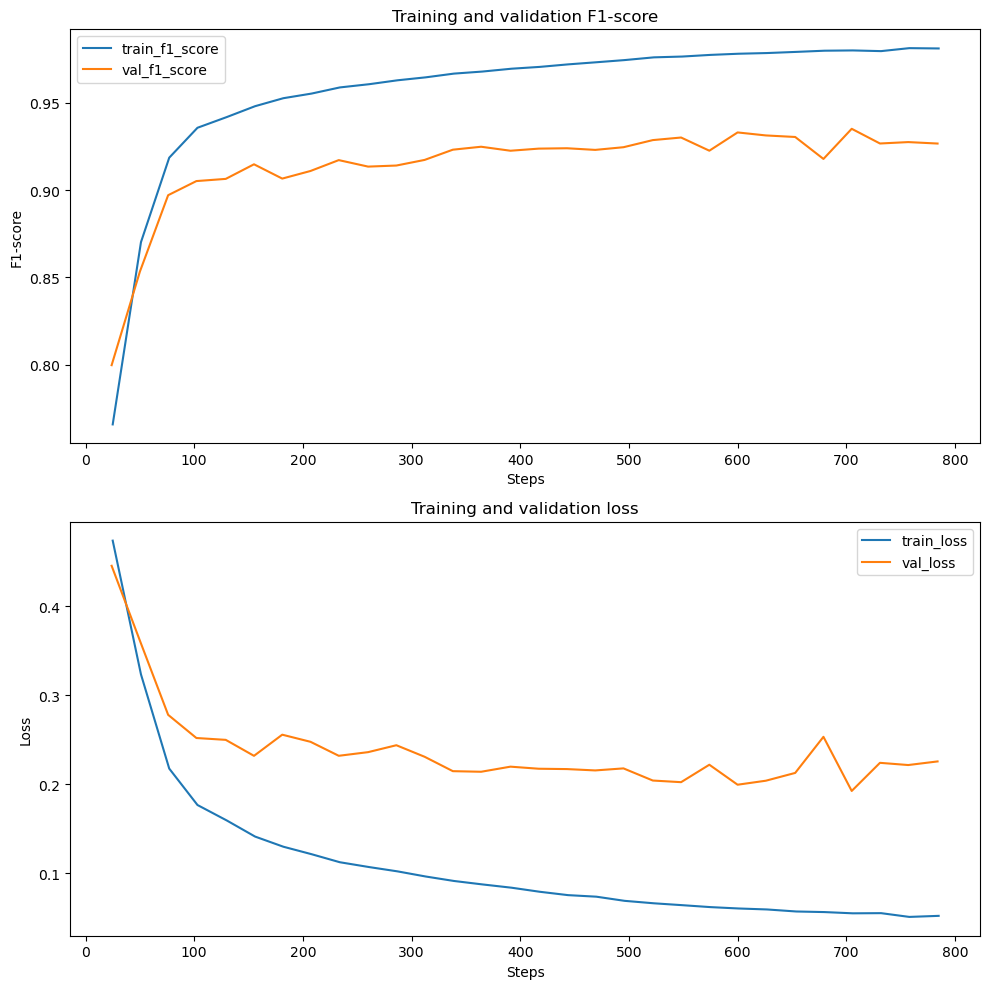

In [12]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_0\metrics.csv')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.9458383917808533     │
│         test_loss         │    0.15829385817050934    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


classification report:
               precision    recall  f1-score   support

   separated       0.91      0.99      0.95      6996
    adjacent       0.99      0.90      0.95      6996

    accuracy                           0.95     13992
   macro avg       0.95      0.95      0.95     13992
weighted avg       0.95      0.95      0.95     13992

F1-score:
 0.9476534109327399
Accuracy:
 0.9477558604917096


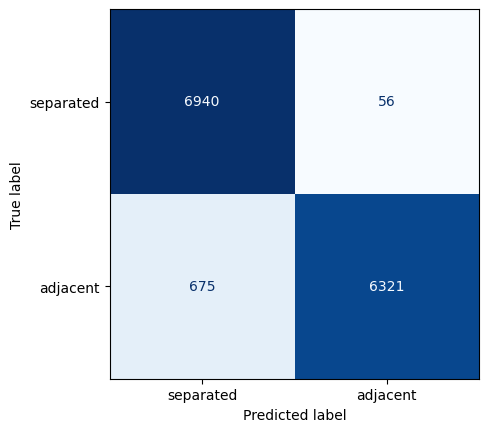

In [13]:
# evaluate pretext model
evaluate_pretext_model(model, test_dataset, test_dataset.labels, batch_size=500)

## Pretext model with weight decay and 0.5 dropout

In [9]:
model = train_pretext_model(
    pretext_task='acrosssub_0.5dropout_0.01wd_pretext_model',
    max_epochs=50,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=1e-5,
    dropout=0.5,
    weight_decay=0.01,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_1\checkpoints\epoch=49-train_loss=0.48-train_f1=0.79-val_loss=0.50-val_f1=0.78.ckpt


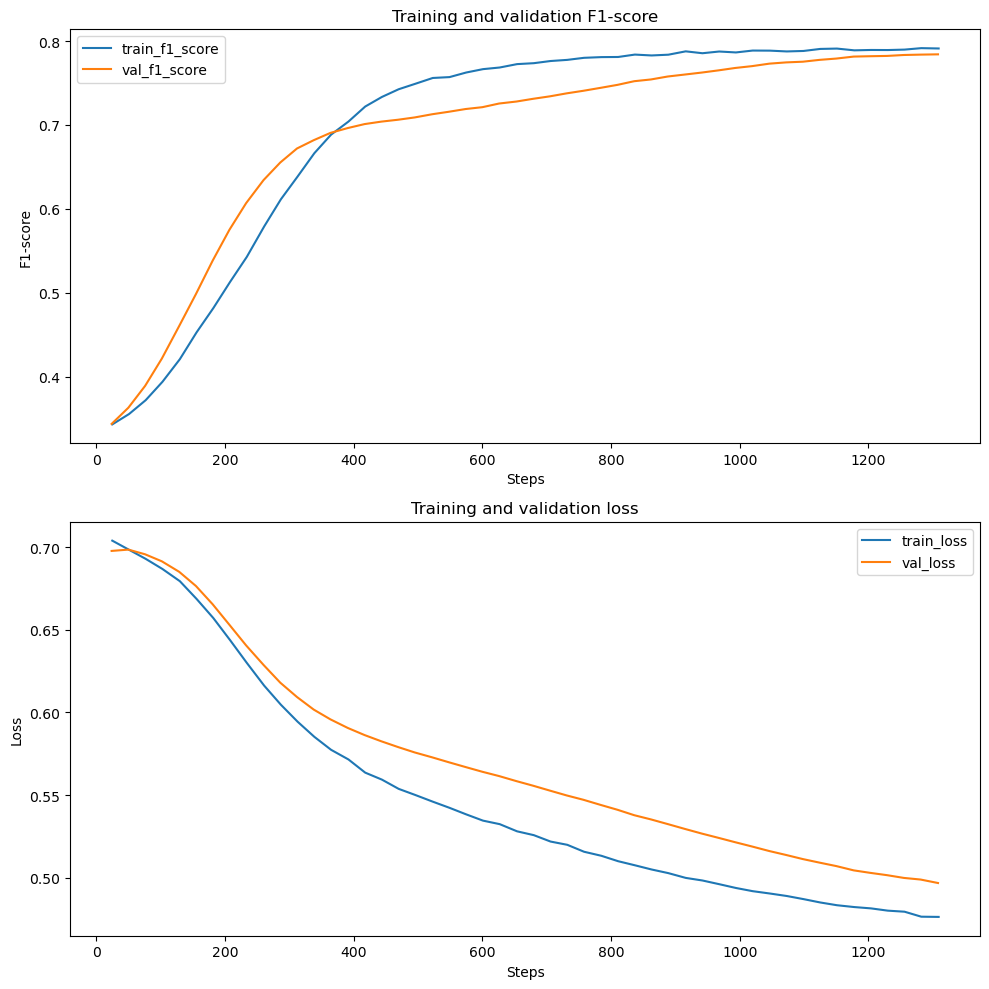

In [10]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_1\metrics.csv')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.7632538080215454     │
│         test_loss         │    0.5143451690673828     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


classification report:
                 precision    recall  f1-score   support

Within-subject       0.78      0.74      0.76      6996
Across-subject       0.75      0.79      0.77      6996

      accuracy                           0.77     13992
     macro avg       0.77      0.77      0.77     13992
  weighted avg       0.77      0.77      0.77     13992

F1-score:
 0.7670051994314808
Accuracy:
 0.7671526586620926


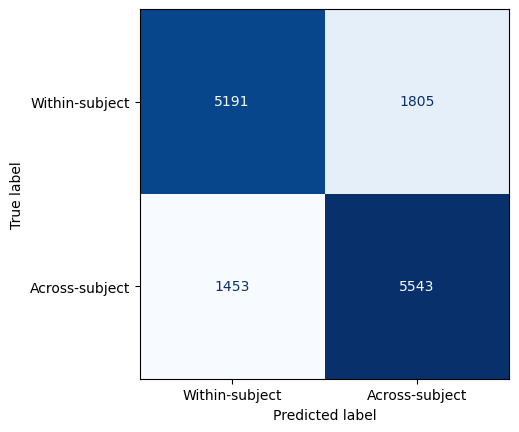

In [11]:
evaluate_pretext_model(model, test_dataset, test_dataset.labels, batch_size=500)

## Pretext model 10 epochs

In [23]:
model = train_pretext_model(
    pretext_task='acrosssub_10epochs_pretext_model',
    max_epochs=10,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    num_extracted_features=100,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_2\checkpoints\epoch=7-train_loss=0.14-train_f1=0.95-val_loss=0.24-val_f1=0.91.ckpt


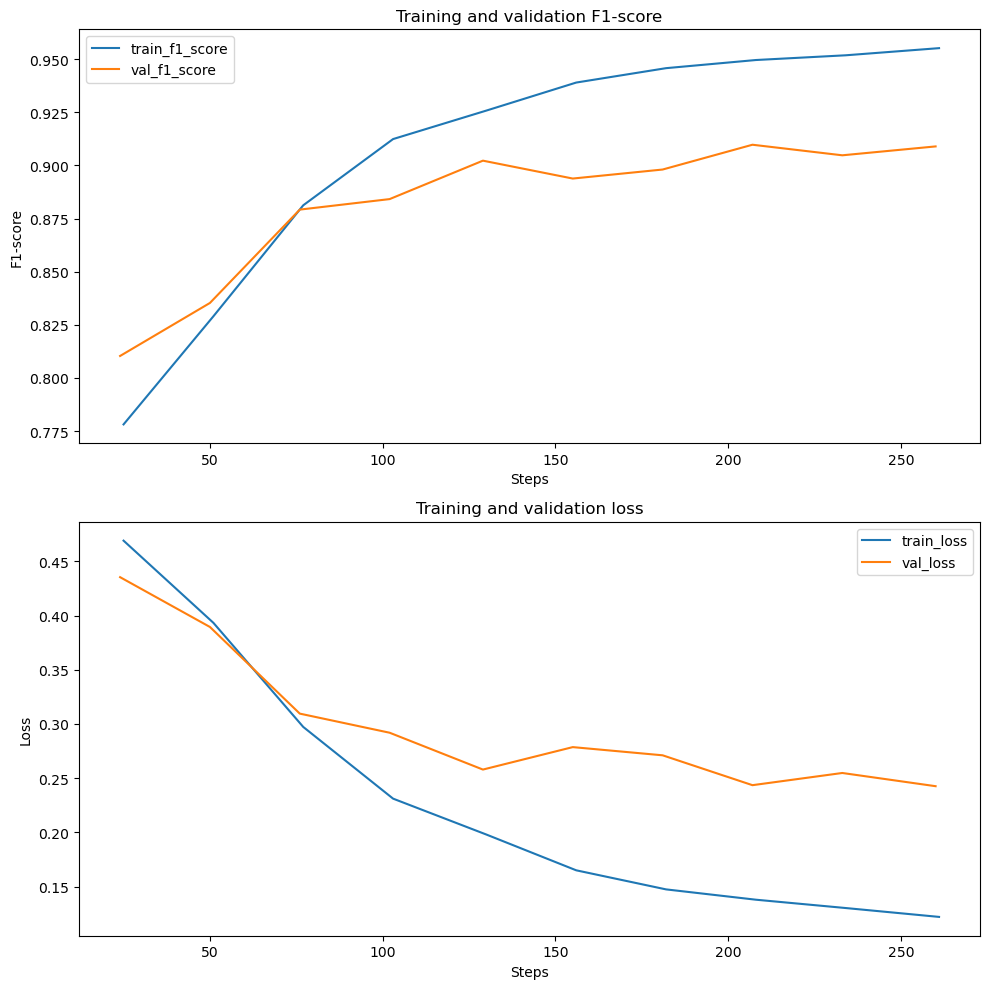

In [24]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_2\metrics.csv')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.9216158390045166     │
│         test_loss         │    0.2121354639530182     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


classification report:
                 precision    recall  f1-score   support

Within-subject       0.89      0.97      0.93      6996
Across-subject       0.97      0.88      0.92      6996

      accuracy                           0.92     13992
     macro avg       0.93      0.92      0.92     13992
  weighted avg       0.93      0.92      0.92     13992

F1-score:
 0.9227109711372675
Accuracy:
 0.9228845054316752


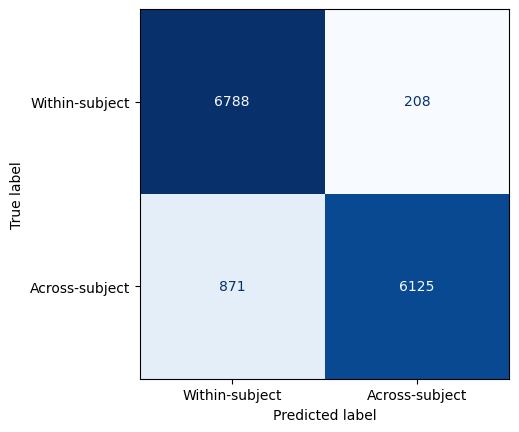

In [25]:
evaluate_pretext_model(model, test_dataset, test_dataset.labels, batch_size=500)

## Pretext model 150 features

In [7]:
model = train_pretext_model(
    pretext_task='acrosssub_150feat_pretext_model',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    num_extracted_features=150,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 95.1 K
1 | linear   | Linear            | 151   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
95.3 K    Trainable params
0         Non-trainable params
95.3 K    Total params
0.381     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Before loading checkpoint:
EEGNet.lin.weight shape: torch.Size([150, 624])
linear.weight shape: torch.Size([1, 150])
Best model checkpoint path: logs\across_sub_pretext_task\version_3\checkpoints\epoch=15-train_loss=0.08-train_f1=0.97-val_loss=0.24-val_f1=0.93.ckpt
After loading checkpoint:
EEGNet.lin.weight shape: torch.Size([150, 624])
linear.weight shape: torch.Size([1, 150])


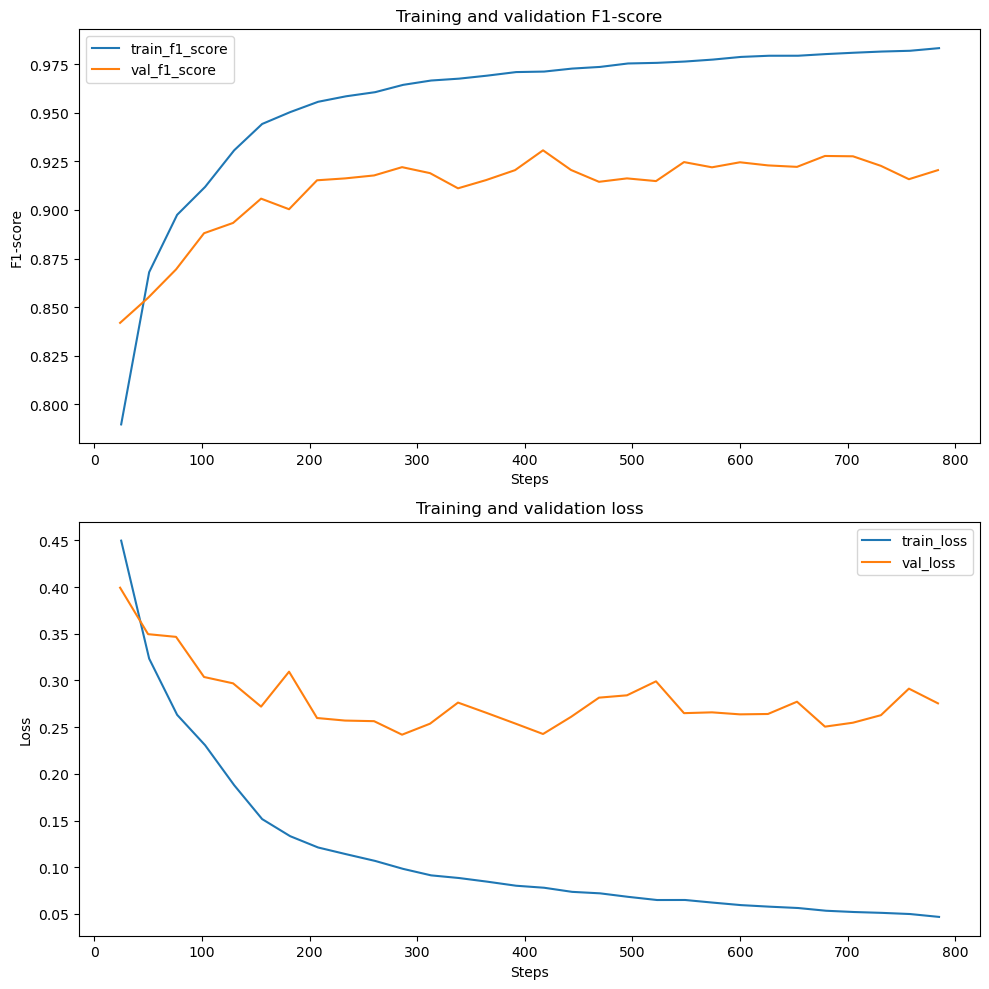

In [8]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_3\metrics.csv')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.9406310319900513     │
│         test_loss         │    0.17842115461826324    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


classification report:
                 precision    recall  f1-score   support

Within-subject       0.91      0.98      0.95      6996
Across-subject       0.98      0.90      0.94      6996

      accuracy                           0.94     13992
     macro avg       0.95      0.94      0.94     13992
  weighted avg       0.95      0.94      0.94     13992

F1-score:
 0.9426541248118341
Accuracy:
 0.9427530017152659


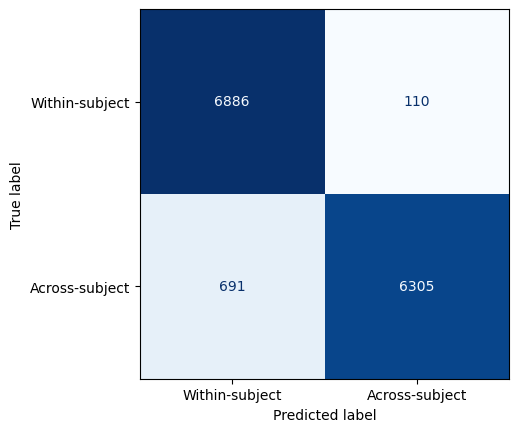

In [9]:
evaluate_pretext_model(model, test_dataset, test_dataset.labels, batch_size=500)

## Training pretext model 50 features

In [8]:
# train pretext model with default parameters
model = train_pretext_model(
    pretext_task='acrosssub_50feat_pretext_model',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    num_extracted_features=50,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 32.7 K
1 | linear   | Linear            | 51    
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
32.8 K    Trainable params
0         Non-trainable params
32.8 K    Total params
0.131     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_8\checkpoints\epoch=22-train_loss=0.08-train_f1=0.97-val_loss=0.20-val_f1=0.94.ckpt


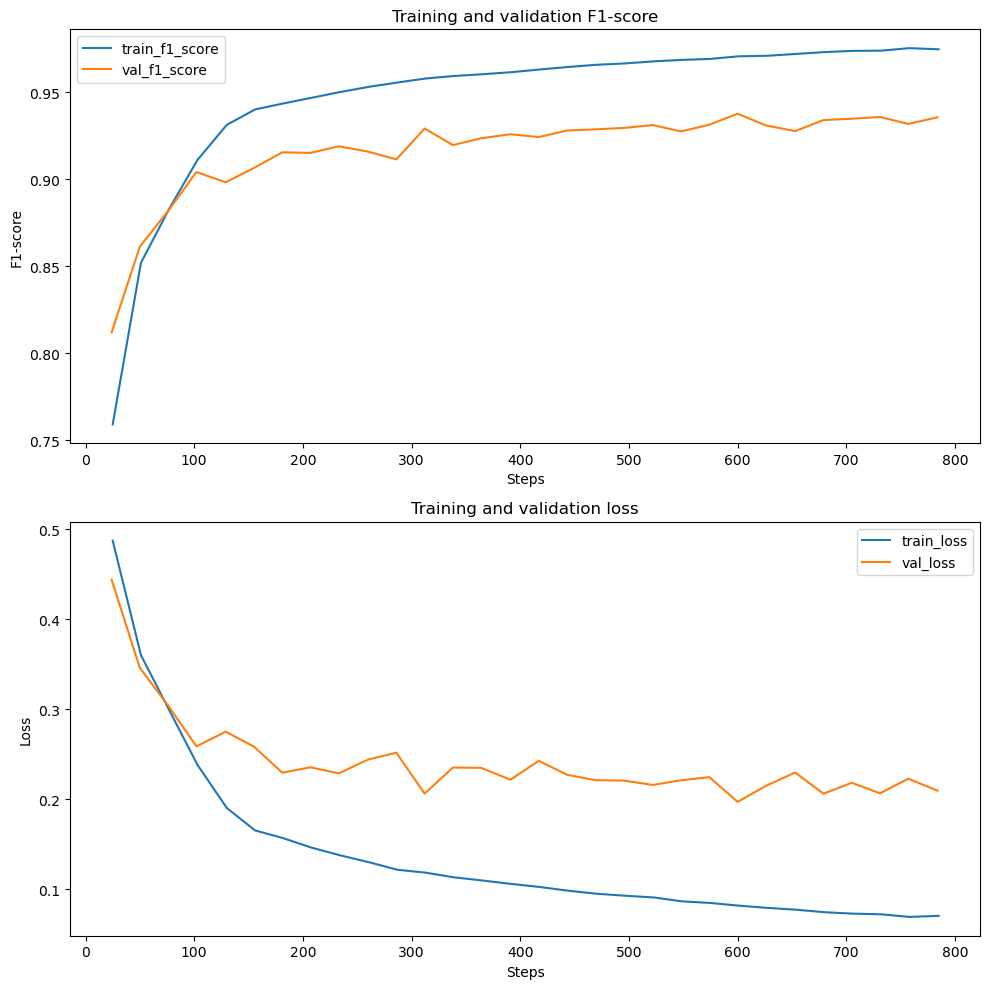

In [9]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_8\metrics.csv')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.9447568655014038     │
│         test_loss         │    0.17682863771915436    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


classification report:
                 precision    recall  f1-score   support

Within-subject       0.92      0.98      0.95      6996
Across-subject       0.98      0.91      0.94      6996

      accuracy                           0.95     13992
     macro avg       0.95      0.95      0.95     13992
  weighted avg       0.95      0.95      0.95     13992

F1-score:
 0.946253092732027
Accuracy:
 0.9463264722698685


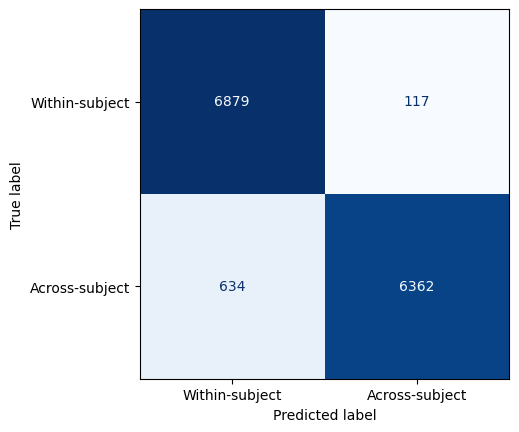

In [10]:
# evaluate pretext model
evaluate_pretext_model(model, test_dataset, test_dataset.labels, batch_size=500)

## Soft Margin Loss

In [4]:
def train_pretext_model(pretext_task,
                        max_epochs,
                        data_train,
                        data_val,
                        batch_size,
                        learning_rate=0.001,
                        dropout=0.25,
                        weight_decay=0,
                        store_weights=(True, True),
                        num_extracted_features=100):
    """
    Function to train the pretext model
    :param pretext_task: title (string) describing the pretext task for saving the model weights
    :param max_epochs: maximum number of epochs to train the model
    :param data_train: training data
    :param data_val: validation data
    :param batch_size: batch size
    :param learning_rate: learning rate
    :param dropout: dropout rate
    :param weight_decay: weight decay
    :param store_weights: whether to store the weights of the overtrained model and the best checkpoint model
    :return: trained model loaded with best checkpoint
    """
    # define the model class (Has to be defined here, otherwise using different amount of extracted features will result in errors)
    # create Conv2d with max norm constraint
    class Conv2dWithConstraint(nn.Conv2d):
        def __init__(self, *args, max_norm: int = 1, **kwargs):
            self.max_norm = max_norm
            super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            self.weight.data = torch.renorm(self.weight.data, p=2, dim=0, maxnorm=self.max_norm)
            return super(Conv2dWithConstraint, self).forward(x)
        
    class EEGNet(nn.Module):
        """
        Code taken and adjusted from pytorch implementation of EEGNet
        url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
        """
        def __init__(self,
                    num_extracted_features: int = num_extracted_features, # number of features to extract  ## QUESTION
                    chunk_size: int = 1244, # number of data points in each EEG chunk
                    num_electrodes: int = 26, # number of EEG electrodes
                    F1: int = 8, # number of filters in first convolutional layer
                    F2: int = 16, # number of filters in second convolutional layer
                    D: int = 2, # depth multiplier
                    kernel_1: int = 64, # the filter size of block 1 (half of sfreq (125 Hz)) ## QUESTION 
                    kernel_2: int = 16, # the filter size of block 2 (one eight of sfreq (500 Hz)) ## QUESTION
                    dropout: float = 0.25): # dropout rate
            super(EEGNet, self).__init__()
            self.F1 = F1
            self.F2 = F2
            self.D = D
            self.chunk_size = chunk_size
            self.num_extracted_features = num_extracted_features
            self.num_electrodes = num_electrodes
            self.kernel_1 = kernel_1
            self.kernel_2 = kernel_2
            self.dropout = dropout

            self.block1 = nn.Sequential(
                nn.Conv2d(1, self.F1, (1, self.kernel_1), stride=1, padding=(0, self.kernel_1 // 2), bias=False),
                nn.BatchNorm2d(self.F1, momentum=0.01, affine=True, eps=1e-3),
                Conv2dWithConstraint(self.F1,
                                    self.F1 * self.D, (self.num_electrodes, 1),
                                    max_norm=1,
                                    stride=1,
                                    padding=(0, 0),
                                    groups=self.F1,
                                    bias=False), nn.BatchNorm2d(self.F1 * self.D, momentum=0.01, affine=True, eps=1e-3),
                nn.ELU(), nn.AvgPool2d((1, 4), stride=4), nn.Dropout(p=dropout))

            self.block2 = nn.Sequential(
                nn.Conv2d(self.F1 * self.D,
                        self.F1 * self.D, (1, self.kernel_2),
                        stride=1,
                        padding=(0, self.kernel_2 // 2),
                        bias=False,
                        groups=self.F1 * self.D),
                nn.Conv2d(self.F1 * self.D, self.F2, 1, padding=(0, 0), groups=1, bias=False, stride=1),
                nn.BatchNorm2d(self.F2, momentum=0.01, affine=True, eps=1e-3), nn.ELU(), nn.AvgPool2d((1, 8), stride=8),
                nn.Dropout(p=dropout))

            self.lin = nn.Linear(self.feature_dim(), num_extracted_features, bias=False)


        def feature_dim(self):
            # function to calculate the number of features after the convolutional blocks
            with torch.no_grad():
                mock_eeg = torch.zeros(1, 1, self.num_electrodes, self.chunk_size)

                mock_eeg = self.block1(mock_eeg)
                mock_eeg = self.block2(mock_eeg)

            return self.F2 * mock_eeg.shape[3]

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            x = self.block1(x)
            x = self.block2(x)
            x = x.flatten(start_dim=1)
            x = self.lin(x)
            return x
        

    class PretextModel(pl.LightningModule):
        """
        Code taken and adjusted from pytorch implementation of EEGNet
        url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
        """
        def __init__(self, num_extracted_features=num_extracted_features, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
            super(PretextModel, self).__init__()
            self.weight_decay = weight_decay
            self.learning_rate = learning_rate
            # feature extractors
            self.EEGNet = EEGNet(num_extracted_features=num_extracted_features, dropout=dropout)
            
            # linear discriminate layer
            self.linear = nn.Linear(num_extracted_features, 1)

            # add metrics
            self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
            self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

        def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
            x1 = self.EEGNet(x1) # forward pass through EEGNet for first sample
            x2 = self.EEGNet(x2) # forward pass through EEGNet for second sample
            z = torch.abs(x1 - x2) # calculate the absolute difference between the two feature vectors (contrastive module)
            x = self.linear(z) # forward pass through linear layer
            return x
        
        def training_step(self, train_batch, batch_idx):
            x = train_batch[0]
            y = train_batch[1]
            y = y
            x1 = x[:, 0, :, :].unsqueeze(1).float()
            x2 = x[:, 1, :, :].unsqueeze(1).float()
            logits = self.forward(x1, x2)
            logits = logits.view(-1)
            loss = F.soft_margin_loss(logits, y, reduce='sum')
            y = torch.where(y == -1, 0, y)
            y_hat = F.sigmoid(logits)
            y_hat = torch.where(y_hat > 0.5, 1, 0)
            self.log('train_loss', loss, on_epoch=True, prog_bar=True)
            self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
            return loss
        
        def validation_step(self, val_batch, batch_idx):
            x = val_batch[0]
            y = val_batch[1]
            y = y
            x1 = x[:, 0, :, :].unsqueeze(1).float()
            x2 = x[:, 1, :, :].unsqueeze(1).float()
            logits = self.forward(x1, x2)
            logits = logits.view(-1)
            loss = F.soft_margin_loss(logits, y, reduce='sum')
            y = torch.where(y == -1, 0, y)
            y_hat = F.sigmoid(logits)
            y_hat = torch.where(y_hat > 0.5, 1, 0)
            self.log('val_loss', loss, prog_bar=True, on_epoch=True)
            self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
            return loss
        
        def test_step(self, test_batch, batch_idx):
            x = test_batch[0]
            y = test_batch[1]
            y = y
            x1 = x[:, 0, :, :].unsqueeze(1).float()
            x2 = x[:, 1, :, :].unsqueeze(1).float()
            logits = self.forward(x1, x2)
            logits = logits.view(-1)
            loss = F.soft_margin_loss(logits, y, reduce='sum')
            y = torch.where(y == -1, 0, y)
            y_hat = F.sigmoid(logits)
            y_hat = torch.where(y_hat > 0.5, 1, 0)
            self.log('test_loss', loss, prog_bar=True)
            self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
            return loss
        
        def predict_step(self, batch):
            x = batch[0]
            x1 = x[:, 0, :, :].unsqueeze(1).float()
            x2 = x[:, 1, :, :].unsqueeze(1).float()
            logits = self.forward(x1, x2)
            logits = logits.view(-1)
            y_hat = F.sigmoid(logits)
            y_hat = torch.where(y_hat > 0.5, 1, 0)
            return y_hat
        
        def configure_optimizers(self):
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
            return optimizer



    # remove particular warnings
    warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
    warnings.filterwarnings("ignore", ".*Trying to infer the `batch_size` from an ambiguous collection*")

    logger = CSVLogger("logs", name="across_sub_pretext_task") # log results to csv file
    torch.set_float32_matmul_precision('high') # for use of tensor cores
    # create pretext model
    model = PretextModel(learning_rate=learning_rate, dropout=dropout, weight_decay=weight_decay, num_extracted_features=num_extracted_features)
    
    # create data loaders
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=False)
    
    checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                    mode='max',
                                    save_top_k=3,
                                    filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                    )

    trainer = Trainer(
        precision='16-mixed',
        accelerator='gpu',
        devices=1,
        max_epochs=max_epochs,
        callbacks=checkpoint_callback,
        enable_progress_bar=True,
        enable_model_summary=True,
        enable_checkpointing=True,
        logger=logger,
        log_every_n_steps=5,
    )

    trainer.fit(model, train_loader, val_loader)

    if store_weights[0]:
        torch.save(model.state_dict(), f'D:/Documents/Master_Data_Science/Thesis/thesis_code/DataScience_Thesis/data/pretext_model_weights/overtrained_{pretext_task}_weights.pt')

    # load best model checkpoint
    print(f"Best model checkpoint path: {checkpoint_callback.best_model_path}")
    best_model = PretextModel.load_from_checkpoint(checkpoint_callback.best_model_path, strict=False)

    if store_weights[1]:
        torch.save(best_model.state_dict(), f'D:/Documents/Master_Data_Science/Thesis/thesis_code/DataScience_Thesis/data/pretext_model_weights/{pretext_task}_weights.pt')

    return best_model

In [5]:
class Across_Subject_Dataset(Dataset):
    def __init__(self, participant_ids, data_path, device='cpu', n_samples=2):
        """
        Dataset for the across subject task. Obtains n combinations of two epochs within a participant and between participants.
        And learns to predict if the two epochs are from the same participant or not.
        :param participant_ids: List of participant IDs
        :param data_path: Path to the directory containing the preprocessed EEG data
        :param device: Device to store the data ('cpu' or 'cuda')
        :param n_samples: Number of samples for each label (adjacent/separate) to generate for each participant combination
        """
        self.participant_ids = participant_ids
        self.data_path = data_path
        self.device = device
        self.n_samples = n_samples
        self.sampled_epochs_indices_id = []
        self.data_cache = {}
        self.labels = []
        self._load_data()

    def _load_data(self):
        epoch_data = {}
        for participant_id in self.participant_ids:
            # Load the data for the participant
            data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))
            # Move data to the specified device
            data = torch.tensor(data)
            data = data.to(self.device)
            self.data_cache[participant_id] = data
        # Generate n combinations of two epochs between two participants
        self.sample_epochs_combinations(self.data_cache, n=self.n_samples)
    
    def sample_epochs_combinations(self, data_cache, n):
        for participant in data_cache.keys():
            data = data_cache[participant]
            n_epochs = data.shape[0]

            # sample n pairs of epochs from the same participant
            within_subject_combos = [comb for comb in itertools.combinations(range(n_epochs), 2)]

            # adjust n if there are not enough within subject samples
            if n > len(within_subject_combos):
                print(f"Warning: asking for {n} within subject samples, but only {len(within_subject_combos)} within subject samples available within participant {participant}.")
                print(f"{len(within_subject_combos)} will be sampled instead of {n}.")
                adj_n = len(within_subject_combos)
            else:
                adj_n = n

            for i, j in random.sample(within_subject_combos, adj_n): # ensure that the same pair is not sampled twice
                self.sampled_epochs_indices_id.append((participant, participant, i, j, 1))
                self.labels.append(1)
            
            # sample n pairs of epochs from the participant and another participant
            for other_participant in random.sample([p for p in data_cache.keys() if p != participant], adj_n):
                other_n_epochs = data_cache[other_participant].shape[0]
                between_subject_combos = list(itertools.product(range(n_epochs), range(other_n_epochs)))
                i, j = random.choice(between_subject_combos)
                self.sampled_epochs_indices_id.append((participant, other_participant, i, j, -1))  
                self.labels.append(-1)    
            
            # delete variables to free up memory
            del within_subject_combos
            del between_subject_combos

        return

    def __len__(self):
        return len(self.sampled_epochs_indices_id)

    def __getitem__(self, idx):
        participant_id_1, participant_id_2, i, j, label = self.sampled_epochs_indices_id[idx]
        # Load the data for the participant on-the-fly
        if participant_id_1 == participant_id_2:
            data = self.data_cache[participant_id_1]
            sampled_epochs = torch.stack([data[i], data[j]])
        if participant_id_1 != participant_id_2:
            data_1 = self.data_cache[participant_id_1]
            data_2 = self.data_cache[participant_id_2]
            epoch_1 = data_1[i]
            epoch_2 = data_2[j]
            sampled_epochs = torch.stack([epoch_1, epoch_2])
        # Convert to PyTorch tensor if it's a NumPy array
        if isinstance(sampled_epochs, np.ndarray):
            sampled_epochs = torch.tensor(sampled_epochs)
        # Transfer data to GPU in batches
        sampled_epochs = sampled_epochs.to('cuda')
        return sampled_epochs, label

#### Data loading & splitting

In [6]:
data_path = r"E:\TDBRAIN\thesis_epoched_data\EC"
participant_ids = get_participant_ids(data_path, epoch_dir=True)
# sample_ids = random.sample(participant_ids, 5)
# separate replication set here, because otherwise combinations between replication and training set would be possible
replication_ids = [par_id for par_id in participant_ids if par_id.startswith('sub-19')] 
training_ids = [par_id for par_id in participant_ids if not par_id.startswith('sub-19')]
test_dataset = Across_Subject_Dataset(replication_ids, data_path, device='cuda', n_samples=66)
train_dataset = Across_Subject_Dataset(training_ids, data_path, device='cuda', n_samples=66)

print(np.unique(train_dataset.labels, return_counts=True))
print(len(train_dataset))
print(train_dataset[0][0].shape)

36 will be sampled instead of 66.
(array([-1,  1]), array([75078, 75078], dtype=int64))
150156
torch.Size([2, 26, 1244])


In [7]:
# split train into train/validation set

groups = [f"{pair[0]}_{pair[1]}" for pair in train_dataset.sampled_epochs_indices_id]
labels = train_dataset.labels


# Assuming trainval_indices is a list of indices for the train dataset
trainval_indices = list(range(len(labels)))

# Stratified group k-fold split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=False)

# Split the train and validation set into train and validation set
for train_idx, val_idx in sgkf.split(trainval_indices, labels, groups):
    train_indices = [trainval_indices[i] for i in train_idx]
    val_indices = [trainval_indices[i] for i in val_idx]
    break  # We only need the first split

del groups
del labels
del trainval_indices

# Save indices to disk
np.save('data_train_indices.npy', train_indices)
np.save('data_val_indices.npy', val_indices)

In [8]:
# obtain actual train, val, test splits
# code from github copilot

# Load indices from disk
data_train_indices = np.load('data_train_indices.npy')
data_val_indices = np.load('data_val_indices.npy')

# Create subsets using the indices
data_train = Subset(train_dataset, data_train_indices)
data_val = Subset(train_dataset, data_val_indices)

# Print dataset sizes and label distributions
train_labels = [train_dataset.labels[i] for i in data_train_indices]
val_labels = [train_dataset.labels[i] for i in data_val_indices]

del data_train_indices
del data_val_indices

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(test_dataset)}")
print(f"Train: {np.unique(train_labels, return_counts=True)}")
print(f"Val: {np.unique(val_labels, return_counts=True)}")
print(f"Test: {np.unique(test_dataset.labels, return_counts=True)}")

Train: 120093, Val: 30063, Test: 13992
Train: (array([-1,  1]), array([60063, 60030], dtype=int64))
Val: (array([-1,  1]), array([15015, 15048], dtype=int64))
Test: (array([-1,  1]), array([6996, 6996], dtype=int64))


#### Training pretext model

In [9]:
model = train_pretext_model(
    pretext_task='acrosssub_soft_margin_loss_pretext_model',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_4\checkpoints\epoch=20-train_loss=0.06-train_f1=0.98-val_loss=0.24-val_f1=0.93.ckpt


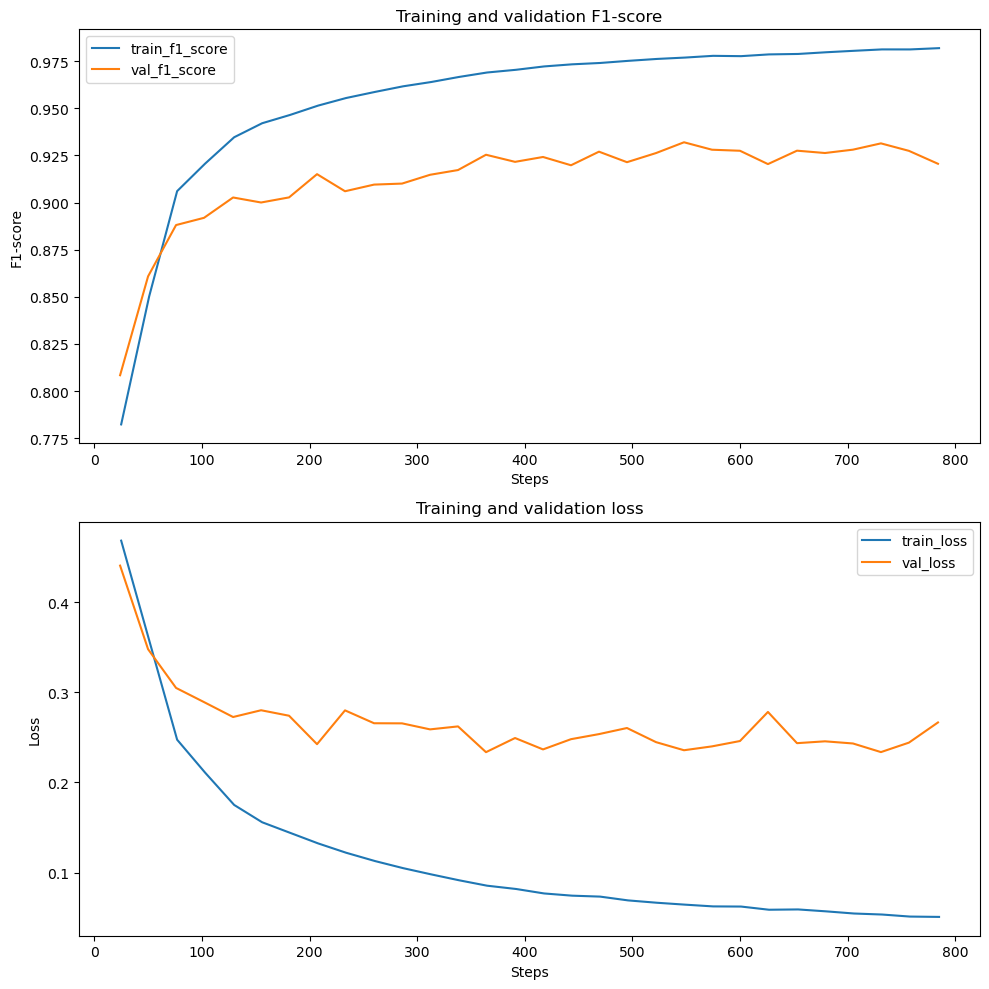

In [10]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_4\metrics.csv')

In [13]:
# evaluate pretext model
evaluate_pretext_model(model, test_dataset, test_dataset.labels, batch_size=500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.9421554803848267     │
│         test_loss         │    0.17650426924228668    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter

#### Training pretext model only 10 epochs

In [11]:
model = train_pretext_model(
    pretext_task='acrosssub_10ep_soft_margin_loss_pretext_model',
    max_epochs=10,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_5\checkpoints\epoch=8-train_loss=0.13-train_f1=0.95-val_loss=0.24-val_f1=0.91.ckpt


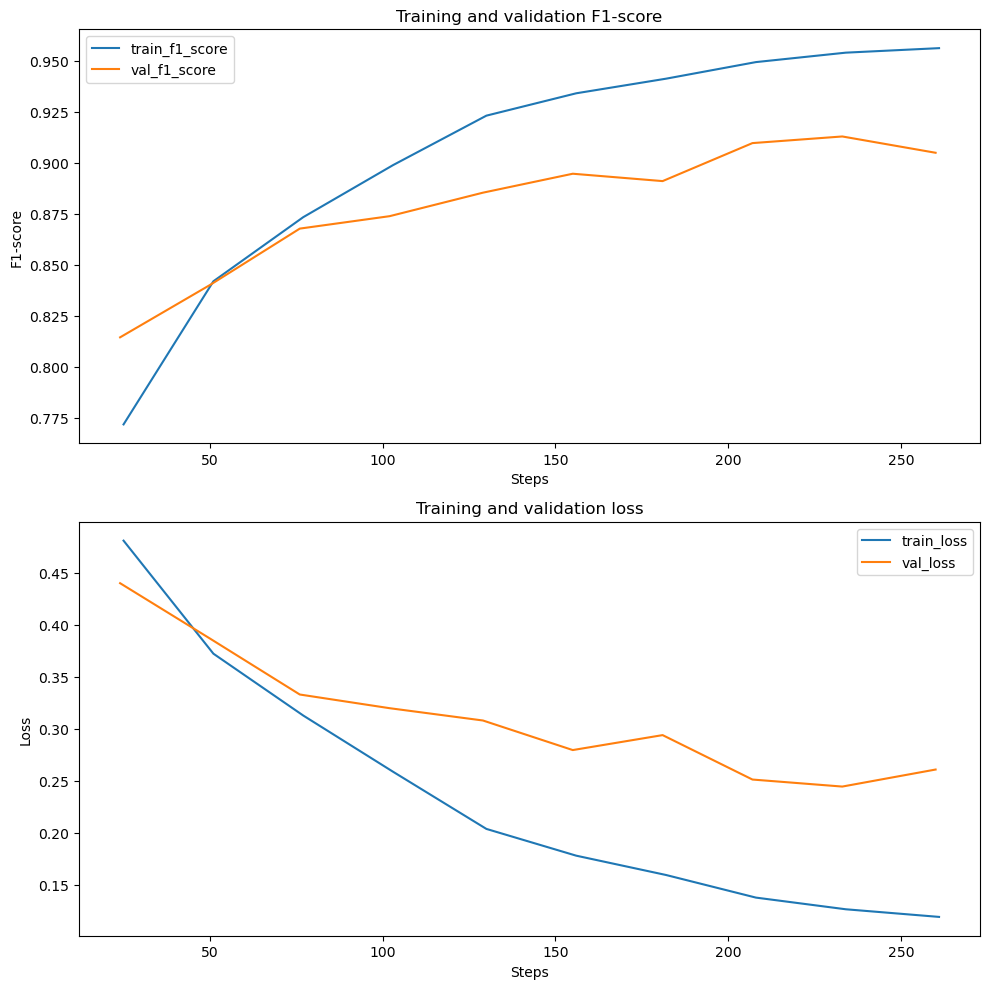

In [12]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_5\metrics.csv')

In [ ]:
# evaluate pretext model
evaluate_pretext_model(model, test_dataset, test_dataset.labels, batch_size=500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.9421554803848267     │
│         test_loss         │    0.17650426924228668    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter

#### Training pretext model 150 features

In [13]:
model = train_pretext_model(
    pretext_task='acrosssub_150feat_soft_margin_loss_pretext_model',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    num_extracted_features=150,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 95.1 K
1 | linear   | Linear            | 151   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
95.3 K    Trainable params
0         Non-trainable params
95.3 K    Total params
0.381     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_6\checkpoints\epoch=27-train_loss=0.06-train_f1=0.98-val_loss=0.23-val_f1=0.93.ckpt


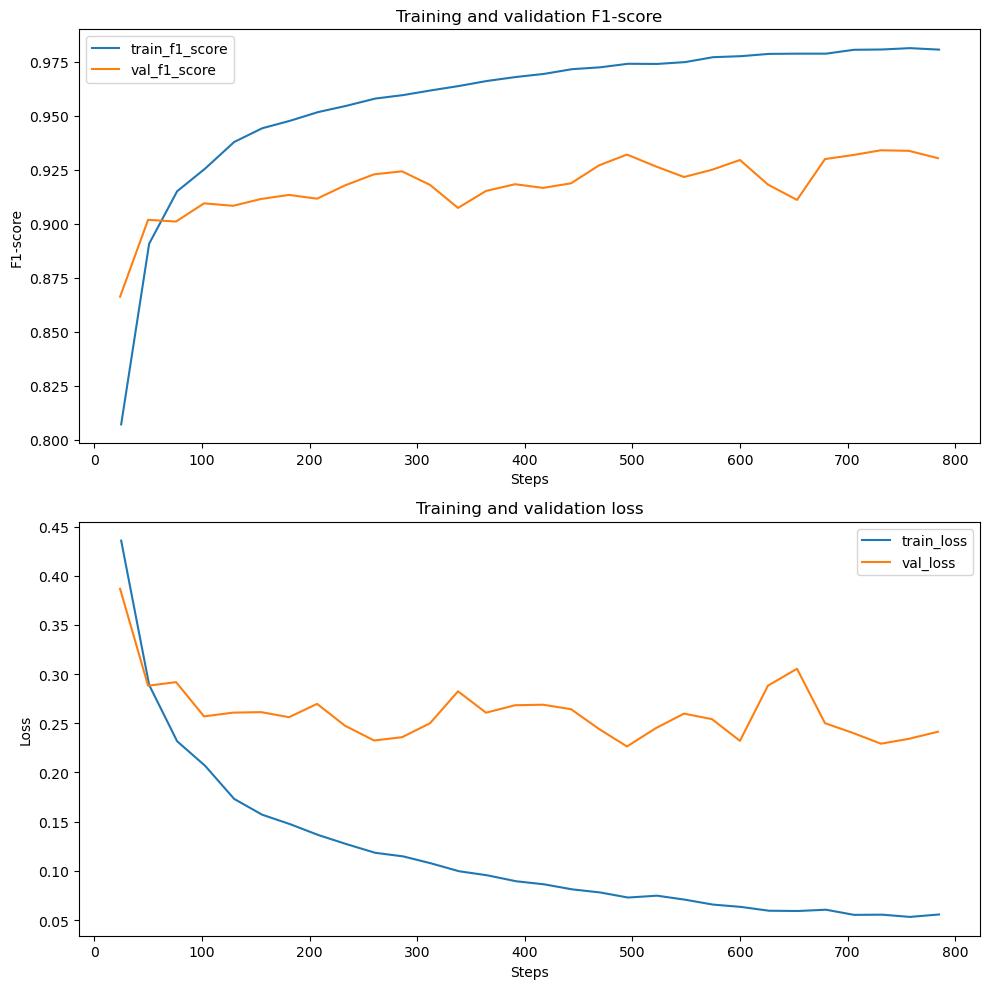

In [14]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_6\metrics.csv')

In [ ]:
# evaluate pretext model
evaluate_pretext_model(model, test_dataset, test_dataset.labels, batch_size=500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.9421554803848267     │
│         test_loss         │    0.17650426924228668    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter

#### Training pretext model only 3 epochs

In [15]:
model = train_pretext_model(
    pretext_task='acrosssub_3ep_soft_margin_loss_pretext_model',
    max_epochs=10,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Best model checkpoint path: logs\across_sub_pretext_task\version_7\checkpoints\epoch=9-train_loss=0.11-train_f1=0.96-val_loss=0.24-val_f1=0.91.ckpt


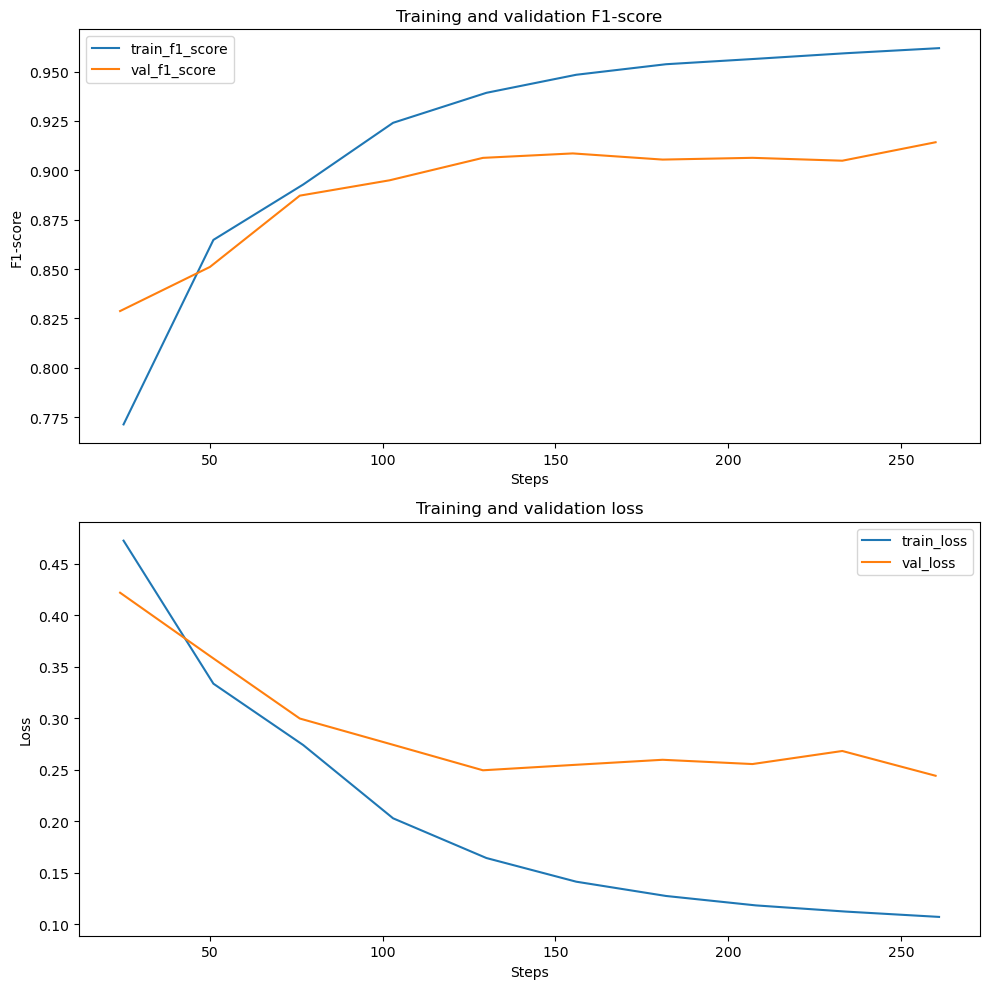

In [16]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_sub_pretext_task\version_7\metrics.csv')

In [ ]:
# evaluate pretext model
evaluate_pretext_model(model, test_dataset, test_dataset.labels, batch_size=500)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.9421554803848267     │
│         test_loss         │    0.17650426924228668    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter